# Tutorial: VQE example for the harmonic oscillator

How to use the Variational Quantum Eigensolver (VQE) in `qiskit` to find the ground state of the quantum harmonic oscillator.

## Define the Hamiltonian for the Schroedinger equation

The Hamiltonian is the sum of the kinetic term and the potential term.
Each term is defined using finite differences on a linearly spaced lattice (1D)

Check out [this blog post](https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8).

### The Schroedinger equation

$$-\frac{1}{2} \frac{d^{2} \psi}{d x^{2}}+V(x) \psi(x)=E \psi(x)$$

First we decide how many qubits we want to use and then we select the boundaries for the 1D grid

In [ ]:
# Here's where the number of qubits are set. The Hamiltonian will be have a size of (N-2)x(N-2)
qubits = 8
N = (2**qubits)+2
print(f"The Hamiltonian will be a {N-2}x{N-2} matrix")

The Hamiltonian will be a 256x256 matrix


In [ ]:
#lattice lower bound
a =  -6
#lattice upper bound
b =  6

### Plot the grid

Discretized grid with 66 sites and step size 0.1846


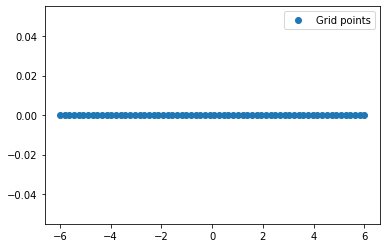

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define x grid and step size
x = np.linspace(a,b,N)
h = x[1]-x[0]

print(f"Discretized grid with {N} sites and step size {h:.4f}")
plt.plot(x,np.zeros(x.shape),'o', label="Grid points")
plt.legend(loc='upper right');

In [ ]:
print(f"The extremal points will not be considered. That is why we have a {N-2}x{N-2} Hamiltonian but {N} points.")

The extremal points will not be considered. That is why we have a 64x64 Hamiltonian but 66 points.


### Potential term and Kinetic term

We use a quadratic potential:
$$
V(x) = \frac{1}{2} x^2
$$

We use finite differences to compute the kinetic term:
$$
T = \frac{1}{2} \frac{\partial^2 \cdot}{\partial x^2} \rightarrow \frac{1}{2} \Big( \frac{\psi(x+1) - 2\psi(x) + \psi(x-1)}{h^2} \Big)
$$

In [ ]:
# Define potential energy function. Change this to change the potential.
def Vpot(x):
    return (1/2)*x**2


# Create Kinetic Energy Matrix
T = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0

# Create Potential Energy Matrix
V = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
# Create Hamiltonian: a big matrix 😂
H = -T/(2*h**2) + V

#### This is an alternative way without for loops, but using indices only

In [ ]:
Tp = np.zeros((N-2,N-2))  # create a kinetic matrix full of zeros 
T_id = np.diag_indices(Tp.shape[0])  # select the indices on the diagonal
T_idp = (T_id[0][:-1],(T_id[1][:-1]+1))  # select the indices above the diagonal y-x=1
T_idm = (T_id[0][:-1]+1,T_id[1][:-1])  # select the indices below the diagonal x-y=1
# fill the 3 "diagonals" with entries for the discretized derivative
Tp[T_id] = -2.0
Tp[T_idp] = Tp[T_idm] = 1.0
# check it is the same as the matrix created with for loops
assert(np.allclose(T,Tp))

In [ ]:
Vp = np.zeros((N-2,N-2))
V_id = np.diag_indices(Vp.shape[0])
Vp[V_id] = Vpot(x[1:-1])
assert(np.allclose(V,Vp))

In [ ]:
# Create Hamiltonian: a big matrix 😂
Hp = -Tp/(2*h**2) + Vp
assert(np.allclose(H,Hp))

### Plot the Hamiltonian

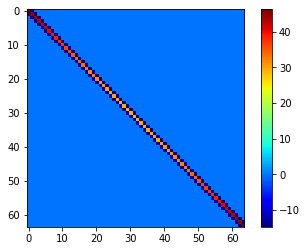

In [ ]:
plt.imshow(H, cmap='jet')
plt.colorbar();

## Solve the Schroedinger equation

We solve the Schroedinger equation by finding the eigenvalues and eigenvectors of the Hamiltonian matrix on the 1D grid defined above.

In [ ]:
# Find eigenvalues and eigenvectors, then sort them in ascending order
val,vec=np.linalg.eig(H)
z = np.argsort(val)
z = z[0:4]
energies=(val[z])
print("Finite Difference Energies for the first 4 states: ", energies)

Finite Difference Energies for the first 4 states:  [0.49893263 1.49465392 2.48607321 3.47316207]


In [ ]:
# Compare finite difference calculation to theoretical calculation
nVec=np.linspace(0,len(energies)-1,len(energies))
En = (nVec + 0.5)
print("Theoretical Energies: ", En)
percentError = ((En-energies)/(energies))*100
print("Percent Error: ", percentError)


Theoretical Energies:  [0.5 1.5 2.5 3.5]
Percent Error:  [0.21393113 0.3576804  0.56019236 0.77272324]


### Plot the wavefunctions

Text(0.5, 1.0, 'normalized wavefunctions for a harmonic oscillator using finite difference method')

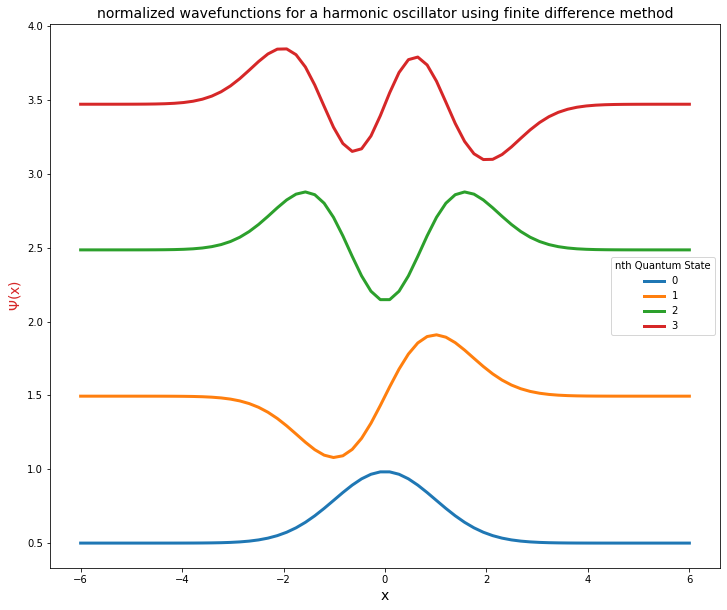

In [ ]:
# Plot wavefunctions for first 4 lowest states
plt.figure(figsize=(12,10))
scalingFactor=1.5
for i in range(len(z)):
    y = []
    y = np.append(y,vec[:,z[i]])
    y = np.append(y,0)
    y = np.insert(y,0,0)
    plt.plot(x,scalingFactor*y+energies[i],lw=3, label="{} ".format(i))
plt.xlabel('x', size=14)
plt.ylabel(r'$\Psi$(x)',size=14,color='tab:red')
plt.legend(title="nth Quantum State")
plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)


## Use QISKIT to solve the problem with quantum algorithms

### Convert the Hamiltonian

Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that Qiskit has added new ways to map Hamiltonians to qubit operators.

In [ ]:
import warnings
import time

from qiskit.opflow import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

qubitOp = MatrixOp(primitive=H)

print("Size of Hamiltonian:", np.shape(H))
print(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Next, we create the variational form.

1.   The plot shows in purple the variational parameters used in the construction of the circuit
2.   The plot shows in blue the entanglement with control gates



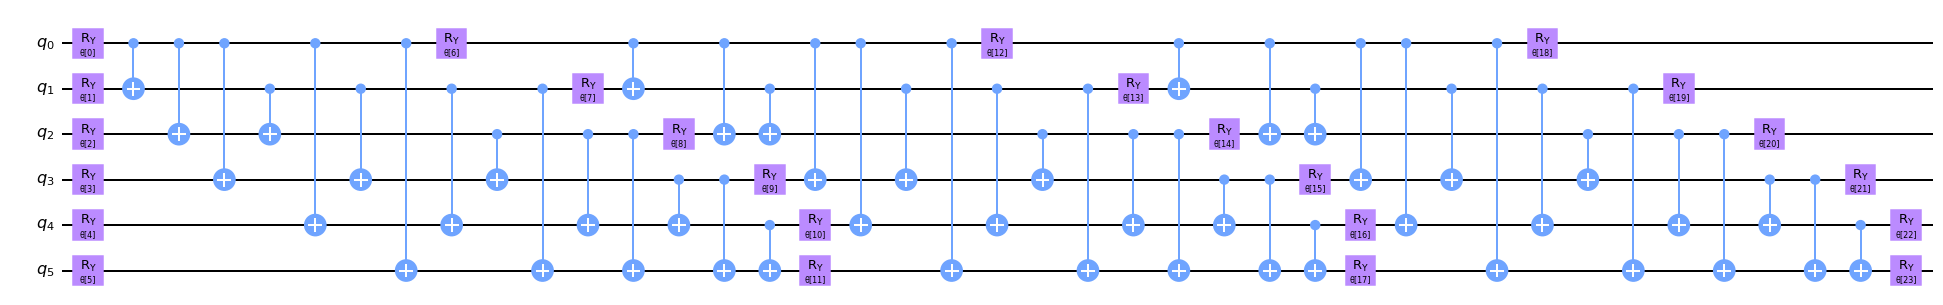

In [ ]:
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In the next cell, we check the exact minimum eigenvalue of the qubit operator to make sure that our Hamiltonian mapped correctly. We should get the same classical result we have seen in the discretized case before

In [ ]:
from qiskit.algorithms import NumPyEigensolver
# exactly diagonalize the system using numpy routines
solver = NumPyEigensolver(k=4)
exact_solution = solver.compute_eigenvalues(qubitOp)
print("Exact Result of qubit hamiltonian:", np.real(exact_solution.eigenvalues))
print("Exact Result of discrete hamiltonian:", energies[0:4])

Exact Result of qubit hamiltonian: [0.49893263]
Exact Result of discrete hamiltonian: 0.498932627777394


### Run the VQE algorithm

Now, we can run the VQE algorithm.

We can use multiple simulators from the QISKIT ecosystem:

- [A statevector simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.StatevectorSimulator.htm)
- [A Qasm simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.html)

In [ ]:
from qiskit import Aer  # change this to Aer for C++ compiled code and the option to run on the GPU
from qiskit.algorithms import VQE

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [ ]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.utils import algorithm_globals, QuantumInstance

warnings.filterwarnings("ignore")

rngseed = 0
algorithm_globals.random_seed = rngseed

if HAS_GPU:
  # with GPU
  backend = Aer.get_backend("statevector_simulator", method="statevector_gpu")
else:
  # without GPU
  backend = Aer.get_backend("statevector_simulator", max_parallel_threads=1, max_parallel_experiments=0)
q_instance = QuantumInstance(
    backend, seed_transpiler=rngseed, seed_simulator=rngseed
)

optimizer = SLSQP(maxiter=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(
    ansatz=var_form,
    optimizer=optimizer,
    quantum_instance=q_instance,
    callback=store_intermediate_result,
)
ret = vqe.compute_minimum_eigenvalue(qubitOp)
vqe_result = np.real(ret.eigenvalue)
print("VQE Result:", vqe_result)

VQE Result: 1.61879053796913
Program runtime: 21.456111431121826 s


Sometimes these results are very bad...we do not get anything close to 0.5

Finally, we plot a convergence plot of the VQE results.

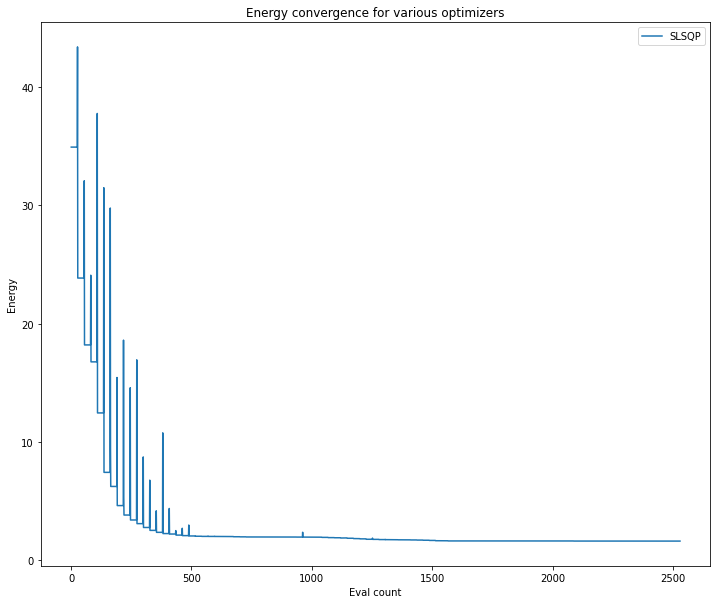

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right')

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [ ]:
ffrom qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance

rngseed = 0
algorithm_globals.random_seed = rngseed

if HAS_GPU:
  backendQasm = Aer.get_backend('qasm_simulator', method="statevector_gpu")
else:
  backendQasm = Aer.get_backend('qasm_simulator', method="statevector")
  
q_instance = QuantumInstance(backend=backendQasm, shots=1024, seed_transpiler=rngseed, seed_simulator=rngseed)
optimizer = SPSA(maxiter=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(
    ansatz=var_form,
    optimizer=optimizer,
    quantum_instance=q_instance,
    callback=store_intermediate_result,
)
ret = vqe.compute_minimum_eigenvalue(qubitOp)
vqe_result = np.real(ret.eigenvalue)
print("VQE Result:", vqe_result)

VQE Result: 2.5247894634219064
Program runtime: 1298.9465007781982 s


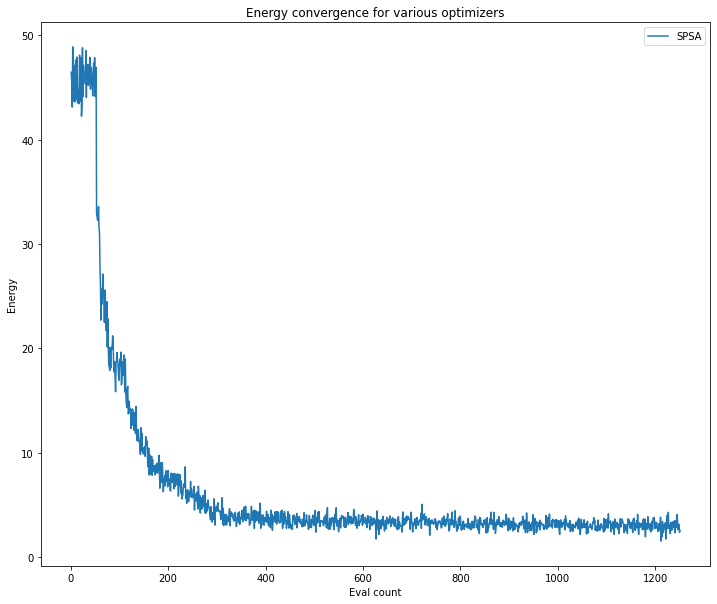

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SPSA")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit': None,
 'qiskit-aer': '0.7.3',
 'qiskit-aqua': '0.8.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-terra': '0.16.3'}